<a href="https://colab.research.google.com/github/jigarsanghavi/TrafficLight_classifier/blob/master/TrafficLight_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
    q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
# print(kaggle_api_key)
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 602M/612M [00:09<00:00, 62.1MB/s]
100% 612M/612M [00:09<00:00, 65.3MB/s]


In [0]:
!unzip /content/gtsrb-german-traffic-sign.zip


In [8]:
import pandas as pd
import numpy as np
import os, shutil
import cv2
from PIL import Image
import imutils
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [0]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout
import time

In [0]:
path = '/content/train'
classes = 43
data = []
labels = []
for filename in range(classes):
  for images in os.listdir(path+'/'+str(filename)):
    path1 = path+'/'+str(filename)+'/'+images
    try:
      img = image.load_img(path1, target_size=(64, 64))
        # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
      x = image.img_to_array(img)
        # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
      x = np.expand_dims(x, axis=0)
      img = preprocess_input(x)
      data.append(img)
      labels.append(filename)
    except:
      print('Error loading image')





In [11]:
img_data = np.asanyarray(data)
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

(39209, 1, 64, 64, 3)
(1, 39209, 64, 64, 3)
(39209, 64, 64, 3)


In [12]:
labels = np.asanyarray(labels)
from keras.utils import to_categorical
labels = to_categorical(labels)
labels.shape

(39209, 43)

In [13]:
x_train,x_val,y_train,y_val = train_test_split(img_data,labels,test_size = 0.2)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(31367, 64, 64, 3) (31367, 43)
(7842, 64, 64, 3) (7842, 43)


In [0]:
from tensorflow.keras.layers import Flatten

In [15]:
input_shape = (64,64,3)
X_input = Input(input_shape) 
    # CONV -> BN -> RELU Block applied to X
X = Conv2D(32, (5, 5), name = 'conv0')(X_input)
X = Activation('relu')(X)
X = Conv2D(32, (5, 5), name = 'conv01')(X)
X = BatchNormalization(axis = 3, name = 'bn01')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool0')(X)
X = Dropout(rate= 0.25)(X)
X = Conv2D(64, (3, 3), name = 'conv1')(X)
X = Activation('relu')(X)
X = Conv2D(64, (3, 3), name = 'conv11')(X)
X = BatchNormalization(axis = 3, name = 'bn1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), name='max_pool1')(X)
X = Dropout(rate= 0.25)(X)
X = Flatten()(X)
X = Dense(256,activation='relu',name='Dense')(X)
output = Dense(43,activation='softmax',name='Output_layer')(X)
model = Model(inputs = X_input, outputs = output, name='Traffic_signal_Detector')  

model.summary()

    

Model: "Traffic_signal_Detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 60, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
conv01 (Conv2D)              (None, 56, 56, 32)        25632     
_________________________________________________________________
bn01 (BatchNormalization)    (None, 56, 56, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 32)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 28, 28,

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
start_time = time.time()

model.fit(x=x_train, y=y_train, batch_size=64, epochs=8, validation_data=(x_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print('execution time:',execution_time)

Epoch 1/8
491/491 [==============================] - 10s 21ms/step - loss: 1.3111 - accuracy: 0.6694 - val_loss: 0.2292 - val_accuracy: 0.9416
Epoch 2/8
491/491 [==============================] - 10s 20ms/step - loss: 0.1048 - accuracy: 0.9709 - val_loss: 0.0660 - val_accuracy: 0.9848
Epoch 3/8
491/491 [==============================] - 10s 20ms/step - loss: 0.0531 - accuracy: 0.9847 - val_loss: 0.0863 - val_accuracy: 0.9741
Epoch 4/8
491/491 [==============================] - 10s 20ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.0632 - val_accuracy: 0.9842
Epoch 5/8
491/491 [==============================] - 10s 20ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.0467 - val_accuracy: 0.9888
Epoch 6/8
491/491 [==============================] - 10s 20ms/step - loss: 0.0286 - accuracy: 0.9908 - val_loss: 0.0513 - val_accuracy: 0.9883
Epoch 7/8
491/491 [==============================] - 10s 20ms/step - loss: 0.0258 - accuracy: 0.9927 - val_loss: 0.0714 - val_accuracy: 0.9819

In [18]:
history = model.history.history
print(history)

{'loss': [1.311109185218811, 0.10483686625957489, 0.05314529314637184, 0.03546769171953201, 0.02791888453066349, 0.028618380427360535, 0.025827383622527122, 0.01898428611457348], 'accuracy': [0.6693658828735352, 0.9708610773086548, 0.9846653938293457, 0.9889055490493774, 0.9910096526145935, 0.9907546043395996, 0.9926674365997314, 0.9937514066696167], 'val_loss': [0.22923661768436432, 0.06596080958843231, 0.08631991595029831, 0.06320154666900635, 0.046663280576467514, 0.05128646641969681, 0.07144913822412491, 0.08632344007492065], 'val_accuracy': [0.941596508026123, 0.9848253130912781, 0.9741137623786926, 0.9841877222061157, 0.9887783527374268, 0.9882683157920837, 0.9818923473358154, 0.9807447195053101]}


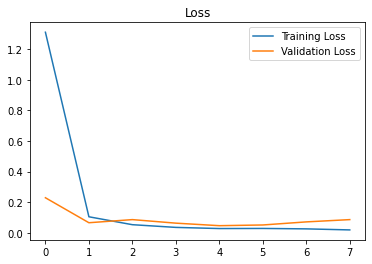

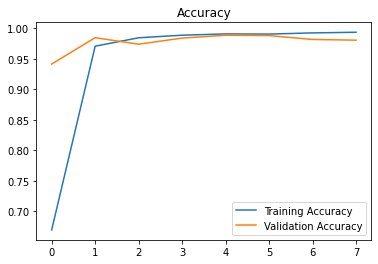

In [19]:
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']
    
    # Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()
    
    # Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [20]:
y_test = pd.read_csv('Test.csv')
y_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [0]:
labels = y_test['ClassId'].values
img_path = y_test['Path'].values

test_data = []
for imgs in img_path:
  img = image.load_img(imgs, target_size=(64, 64))
        # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
  img = image.img_to_array(img)
  img = preprocess_input(img)
  test_data.append(img)
test_data = np.asanyarray(test_data)

pred_labels = model.predict(test_data)

In [0]:
pred_class = []
for classes in pred_labels:
  pred_class.append(np.argmax(classes))



In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,pred_class)

0.9523357086302454

In [0]:
model.save('TrafficLight_classifier.h5')

In [0]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
#load the trained model to classify sign
from keras.models import load_model
model = load_model('TrafficLight_classifier.h5')
#dictionary to label all traffic signs class.
classes = { 1:'Speed limit (20km/h)',
            2:'Speed limit (30km/h)', 
            3:'Speed limit (50km/h)', 
            4:'Speed limit (60km/h)', 
            5:'Speed limit (70km/h)', 
            6:'Speed limit (80km/h)', 
            7:'End of speed limit (80km/h)', 
            8:'Speed limit (100km/h)', 
            9:'Speed limit (120km/h)', 
            10:'No passing', 
            11:'No passing veh over 3.5 tons', 
            12:'Right-of-way at intersection', 
            13:'Priority road', 
            14:'Yield', 
            15:'Stop', 
            16:'No vehicles', 
            17:'Veh > 3.5 tons prohibited', 
            18:'No entry', 
            19:'General caution', 
            20:'Dangerous curve left', 
            21:'Dangerous curve right', 
            22:'Double curve', 
            23:'Bumpy road', 
            24:'Slippery road', 
            25:'Road narrows on the right', 
            26:'Road work', 
            27:'Traffic signals', 
            28:'Pedestrians', 
            29:'Children crossing', 
            30:'Bicycles crossing', 
            31:'Beware of ice/snow',
            32:'Wild animals crossing', 
            33:'End speed + passing limits', 
            34:'Turn right ahead', 
            35:'Turn left ahead', 
            36:'Ahead only', 
            37:'Go straight or right', 
            38:'Go straight or left', 
            39:'Keep right', 
            40:'Keep left', 
            41:'Roundabout mandatory', 
            42:'End of no passing', 
            43:'End no passing veh > 3.5 tons' }
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Traffic sign classification')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
top=tk.Tk()
top.geometry('800x600')
top.title('Traffic sign classification')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((30,30))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    pred = model.predict([image])
    pred = np.argmax(pred)
    sign = classes[pred+1]
    print(sign)
    label.configure(foreground='#011638', text=sign) 
def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",command=lambda: classify(file_path),padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)
def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Know Your Traffic Sign",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()
